In [86]:
import kagglehub
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import confusion_matrix, classification_report

In [58]:
# Downloading the dataset
path = Path(kagglehub.dataset_download("shashwatwork/identifying-disease-in-tea-leafs")) / "tea sickness dataset"

## Exploring the dataset

In [59]:
class_distribution = Counter()
for class_dir in path.iterdir():
    if class_dir.is_dir():
        num_images = len(list(class_dir.glob("*.*")))
        class_distribution[class_dir.name] = num_images

num_classes = len(class_distribution)

print(f"🔎 Found {num_classes} classes:\n")
for class_name, count in class_distribution.items():
    print(f"✦ {class_name}: {count} images")

🔎 Found 8 classes:

✦ white spot: 142 images
✦ Anthracnose: 100 images
✦ healthy: 74 images
✦ gray light: 100 images
✦ bird eye spot: 100 images
✦ algal leaf: 113 images
✦ brown blight: 113 images
✦ red leaf spot: 143 images


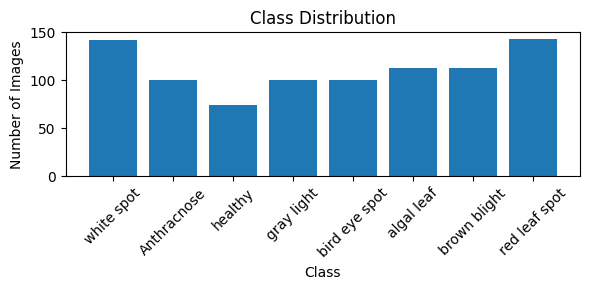

In [60]:
plt.figure(figsize=(6, 3))
classes = list(class_distribution.keys())
counts = list(class_distribution.values())
plt.bar(classes, counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

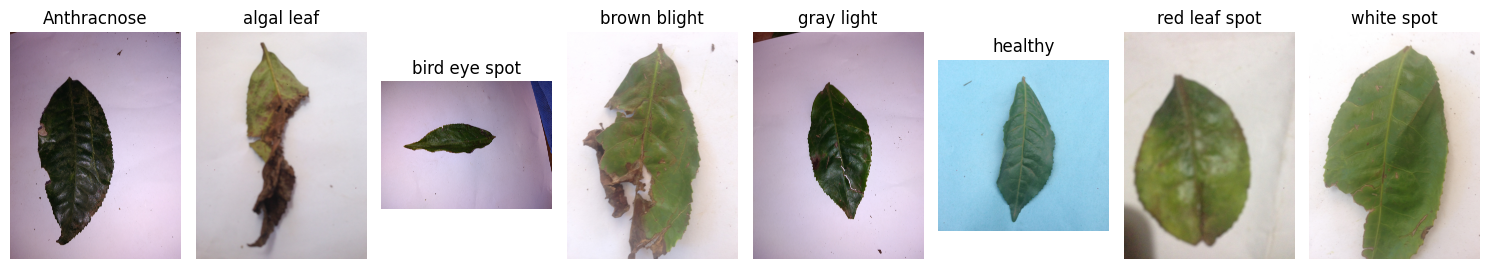

In [61]:
# Displaying one image from each class
class_dirs = sorted([d for d in path.iterdir() if d.is_dir()])
plt.figure(figsize=(15, 2.5 * num_classes))
for idx, class_dir in enumerate(class_dirs, start=1):
    image_files = list(class_dir.glob("*.*"))
    if not image_files:
        continue
    img_path = random.choice(image_files)
    img = Image.open(img_path)
    
    plt.subplot(1, num_classes, idx)
    plt.imshow(img)
    plt.title(class_dir.name)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Data Augmentation and Preprocessing

In [62]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [63]:
dataset = datasets.ImageFolder(path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Model

In [64]:
# Loading pre-trained EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, num_classes) # classifier (last layer)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

Loaded pretrained weights for efficientnet-b0


In [65]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Tracking loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct / total

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Tracking loss and accuracy
                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

In [66]:
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10] - Train Loss: 1.9311, Train Accuracy: 0.3362, Val Loss: 1.9404, Val Accuracy: 0.3107
Epoch [2/10] - Train Loss: 1.5827, Train Accuracy: 0.6088, Val Loss: 1.7451, Val Accuracy: 0.4520
Epoch [3/10] - Train Loss: 1.2213, Train Accuracy: 0.7076, Val Loss: 1.4936, Val Accuracy: 0.5650
Epoch [4/10] - Train Loss: 0.9178, Train Accuracy: 0.7585, Val Loss: 1.2177, Val Accuracy: 0.6045
Epoch [5/10] - Train Loss: 0.7360, Train Accuracy: 0.7726, Val Loss: 0.9436, Val Accuracy: 0.6836
Epoch [6/10] - Train Loss: 0.6246, Train Accuracy: 0.8037, Val Loss: 0.8239, Val Accuracy: 0.6836
Epoch [7/10] - Train Loss: 0.5329, Train Accuracy: 0.8220, Val Loss: 0.7443, Val Accuracy: 0.7119
Epoch [8/10] - Train Loss: 0.4415, Train Accuracy: 0.8672, Val Loss: 0.6732, Val Accuracy: 0.7514
Epoch [9/10] - Train Loss: 0.3893, Train Accuracy: 0.8686, Val Loss: 0.5890, Val Accuracy: 0.7853
Epoch [10/10] - Train Loss: 0.3750, Train Accuracy: 0.8814, Val Loss: 0.4885, Val Accuracy: 0.7910


## Evaluating the Model

In [80]:
output_dir = Path("output")
output_dir.mkdir(parents=True, exist_ok=True)

In [81]:
def plot_confusion_matrix(model, val_loader, path='output/confusion_matrix.png'):
    model.eval()  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.close()


In [82]:
plot_confusion_matrix(model, val_loader)

In [83]:
def gen_classification_report(model, val_loader, path='output/classification_report.txt'):
    model.eval()  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print(report)

    with open(path, "w") as f:
        f.write(report)

In [84]:
gen_classification_report(model, val_loader)

               precision    recall  f1-score   support

  Anthracnose       1.00      0.45      0.62        11
   algal leaf       0.92      0.85      0.88        26
bird eye spot       0.94      0.58      0.71        26
 brown blight       0.83      0.79      0.81        24
   gray light       0.40      1.00      0.57        12
      healthy       1.00      1.00      1.00        13
red leaf spot       1.00      0.97      0.99        38
   white spot       0.72      0.78      0.75        27

     accuracy                           0.81       177
    macro avg       0.85      0.80      0.79       177
 weighted avg       0.87      0.81      0.82       177



## Saving the Model

In [85]:
torch.save(model.state_dict(), "output/efficientnet_tea_classifier_v1.pth")